# Style Transfer Net

We are going to now turn the super resolution network from fast.ai lesson 14 [`enhance.ipynb` notebook](enhance.ipynb) into a style transfer network.

It's really combining two things we've already done—one, super resolution for comparing our input image should look like itself by the end and two, style should look like some painting which we'll do just like we did with Leon Gatys' approach by looking at the Gram matrix correspondence at a number of layers.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

All this code starts identical, except we don't have high res and low res, we just have one size 256px images.

In [2]:
from fastai.conv_learner import *
from pathlib import Path
# torch.cuda.set_device(0)

torch.backends.cudnn.benchmark = True

In [3]:
PATH = Path('data/imagenet')
PATH_TRN = PATH / 'train'

In [4]:
fnames_full, label_arr_full, all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5], label_arr_full[:5]))

[('n01440764/n01440764_12241.JPEG', 0),
 ('n01440764/n01440764_529.JPEG', 0),
 ('n01440764/n01440764_11155.JPEG', 0),
 ('n01440764/n01440764_9649.JPEG', 0),
 ('n01440764/n01440764_8013.JPEG', 0)]

In [5]:
all_labels[:5]

['n01440764', 'n01443537', 'n01491361', 'n01494475', 'n01498041']

In [6]:
np.random.seed(42)
keep_pct = 1.
# keep_pct = 0.1
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [7]:
arch = vgg16

# sz, bs = 96, 32
sz, bs = 256, 24
# sz, bs = 128, 32

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)

    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))

    def get_c(self): return 0

In [9]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x), len(trn_x)

(194, 19245)

In [10]:
img_fn = PATH / 'train' / 'n01558993' / 'n01558993_9684.JPEG'

In [11]:
tfms = tfms_from_model(arch, sz, tfm_y=TfmType.PIXEL)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [12]:
denorm = md.val_ds.denorm

In [13]:
def show_img(ims, idx, figsize=(5, 5), normed=True, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims), 1, 4)
    ax.imshow(np.clip(ims, 0, 1)[idx])
    ax.axis('off')

## Model

In [14]:
def conv(ni, nf, kernel_size=3, stride=1, actn=True, pad=None, bn=True):
    if pad is None: pad = kernel_size//2
    layers = [nn.Conv2d(ni, nf, kernel_size, stride=stride, padding=pad, bias=not bn)]
    if actn: layers.append(nn.ReLU(inplace=True))
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

We got batch norm layers. We don't have scaling factor here:

In [15]:
class ResSequentialCenter(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x[:, :, 2:-2, 2:-2] + self.m(x)

In [16]:
def res_block(nf):
    return ResSequentialCenter([conv(nf, nf, actn=True, pad=0), conv(nf, nf, pad=0)])

We don't have a pixel shuffle — it's just using a normal upsampling followed by 1x1 conf. So it's just more normal.

In [17]:
def upsample(ni, nf):
    return nn.Sequential(nn.Upsample(scale_factor=2), conv(ni, nf))

One thing they mentioned in the paper is they had a lot of problems with zero padding creating artifacts and the way they solved that was by adding 40 pixel of reflection padding at the start. So I did the same thing and then they used zero padding in their convolutions in their Res blocks. Now if you've got zero padding in your convolutions in your Res blocks, then that means that the two parts of your ResNet won't add up anymore because you've lost a pixel from each side on each of your two convolutions. So my `ResSequential` has become `ResSequentialCenter` and I've removed the last 2 pixels on each side of those good cells. Other than that, this is basically the same as what we had before.

In [18]:
class StyleResnet(nn.Module):
    def __init__(self):
        super().__init__()
        features = [
            nn.ReflectionPad2d(40),
            conv(3, 32, 9),
            conv(32, 64, stride=2),
            conv(64, 128, stride=2)
        ]
        for i in range(5):
            features.append(res_block(128))
        features += [
            upsample(128, 64),
            upsample(64, 32),
            conv(32, 3, 9, actn=False)
        ]
        self.features = nn.Sequential(*features)
        
    def forward(self, x):
        return self.features(x)

## Style Image

In [19]:
style_fn = PATH / 'style' / 'starry_night.jpg'
style_img = open_image(style_fn)
style_img.shape

(900, 1136, 3)

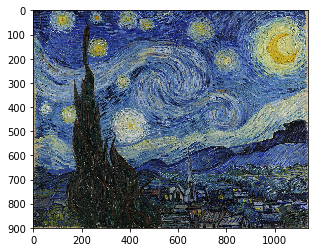

In [20]:
plt.imshow(style_img)

We can resize it.

In [21]:
h, w, _ = style_img.shape
rat = max(sz / h, sz / h)
res = cv2.resize(style_img, (int(w * rat), int(h * rat)), interpolation=cv2.INTER_AREA)
resz_style = res[:sz, -sz:]

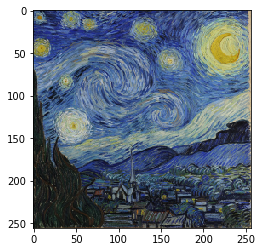

In [22]:
plt.imshow(resz_style)

We can throw it through our transformations.

In [23]:
style_tfm, _ = tfms[1](resz_style, resz_style)

Just to make the method a little bit easier for my brain to handle, I took our transform style image which after transformations of 3 x 256 x 256, and I made a mini batch. My batch size is 24 — 24 copies of it. It just makes it a little bit easier to do the kind of batch arithmetic without worrying about some of the broadcasting. They are not really 24 copies. I used `np.broadcast` to basically fake 24 pieces.

In [24]:
style_tfm = np.broadcast_to(style_tfm[None], (bs,) + style_tfm.shape)

In [25]:
style_tfm.shape

(24, 3, 256, 256)

## Perceptual loss

So just like before, we create a VGG, grab the last block. This time we are going to use all of these layers so we keep everything up to the 43rd layer.

In [26]:
m_vgg = vgg16(True)

In [27]:
blocks = [i - 1 for i, o in enumerate(children(m_vgg))
                    if isinstance(o, nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks[1:]]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [28]:
vgg_layers = children(m_vgg)[:43]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [29]:
def flatten(x): return x.view(x.size(0), -1)

In [30]:
class SaveFeatures():
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [31]:
def ct_loss(input, target): return F.mse_loss(input, target)

def gram(input):
    b, c, h, w = input.size()
    x = input.view(b, c, -1)
    return torch.bmm(x, x.transpose(1, 2)) / (c * h * w) *1e6

def gram_loss(input, target):
    return F.mse_loss(gram(input), gram(target[:input.size(0)]))

Now our combined loss is going to add together a content loss for the third block plus the Gram loss for all of our blocks with different weights.

In [32]:
class CombinedLoss(nn.Module):
    def __init__(self, m, layer_ids, style_im, ct_wgt, style_wgts):
        super().__init__()
        self.m, self.ct_wgt, self.style_wgts = m, ct_wgt, style_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
        m(VV(style_im))
        self.style_feat = [V(o.features.data.clone()) for o in self.sfs]
        
    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        targ_feat = self.sfs[2].features.data.clone()
        self.m(input)
        inp_feat = [o.features for o in self.sfs]
        
        res = [ct_loss(inp_feat[2], V(targ_feat)) * self.ct_wgt]
        res += [gram_loss(inp, targ) * wgt for inp, targ, wgt
                in zip(inp_feat, self.style_feat, self.style_wgts)]
        
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

So I've got Gram matrices, I do my MSE loss between the Gram matrices, I weight them by style weights, so I create that ResNet.

In [33]:
m = StyleResnet()

In [34]:
m = to_gpu(m)

In [35]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

I create my combined loss passing in the VGG network, passing in the block IDs, passing in the transformed starry night image, and you'll see the the very start here, I do a forward pass through my VGG model with that starry night image in order that I can save the features for it.

In [36]:
learn.crit = CombinedLoss(m_vgg, blocks[1:], style_tfm, 1e4, [0.025, 0.275, 5., 0.2])

### Train

In [37]:
wd = 1e-7

 49%|████▊     | 390/802 [16:33<17:29,  2.55s/it, loss=1.86e+06]

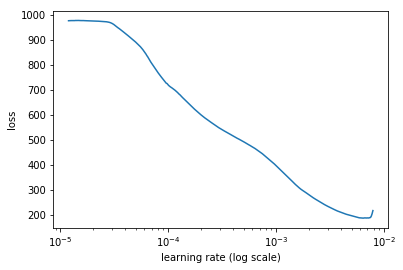

In [38]:
learn.lr_find(wds=wd)
learn.sched.plot(n_skip_end=1)

In [39]:
lr = 5e-3

In [41]:
%time learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss                             
    0      116.030613 115.316882
CPU times: user 37min 11s, sys: 2min 50s, total: 40min 2s
Wall time: 33min 40s


[array([115.31688])]

In [42]:
learn.save('style-transfer-net-1')

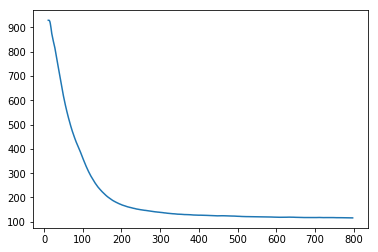

In [43]:
learn.sched.plot_loss()

### Evaluate the results

In [50]:
x, y = md.val_ds[1]

In [51]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape, y.shape, preds.shape

((3, 256, 256), (3, 256, 256), torch.Size([1, 3, 256, 256]))

Note, `sum_layers=False` so we can see what each part looks like and see they are balanced

In [52]:
learn.crit(preds, VV(y[None]), sum_layers=False)

[Variable containing:
  61.2578
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  3.3731
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  4.3279
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  4.6045
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  41.2980
 [torch.cuda.FloatTensor of size 1 (GPU 0)]]

In [57]:
learn.crit.close()

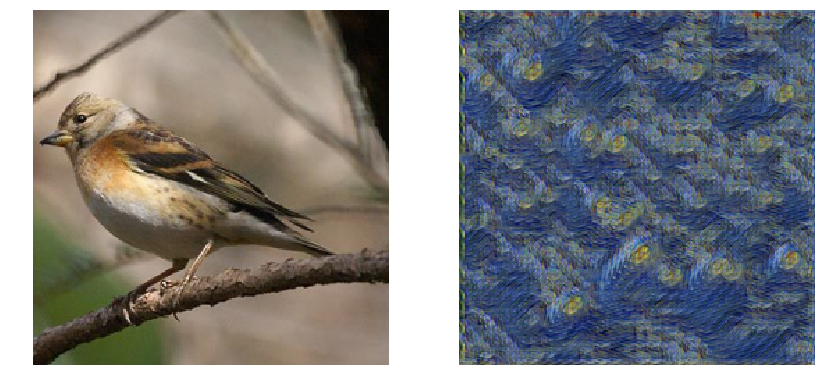

In [56]:
_, axes = plt.subplots(1, 2, figsize=(14, 7))
show_img(x[None], 0, ax=axes[0])
show_img(preds, 0, normed=True, ax=axes[1])

### Final analysis

To make it looks great, it's really about getting the exact right mix of content loss and a style loss and the mix of the layers of the style loss. The worst part was it takes a really long time to train the darn CNN and I didn't really know how long to train it before I decided it wasn't doing well. Should I just train it for longer? And I don't know all the little details didn't seem to slightly change it but just it would totally fall apart all the time.

It was fiddly getting this style transfer to work. After doing it, it left me thinking why did I bother because now I've got something that takes hours to create a network that can turn any kind of photo into one specific style.

I think there's a lot of really cool techniques here. It's also leveraging a lot of stuff that we've been learning and getting better and better at.